In [1]:
import jax
import jax.numpy as np

from elrpy.dgp import normal_sim_binary
from elrpy.losses import lyapunov_binary_loss, get_wrapped_loss
from elrpy.optim import get_cg_fn, fit
from elrpy.utils import get_bootstrap_weights
from elrpy.models import init_binary

In [2]:
rng = jax.random.PRNGKey(0)
n=10_000
d=3
k=100
rng, next_rng = jax.random.split(rng)
beta, gamma, X, Y_X, Y, G = normal_sim_binary(next_rng, n, d, k)
# group_data = group_Xs, group_Ys, group_Ns

# num_groups, dim, num_outcomes = get_dims((group_Xs, group_Xs, group_Ns))
# model_fn, model_params = init_binary(dim)

In [3]:
model_fn, model_params = init_binary(X)

In [4]:
wrapped_loss_fn = get_wrapped_loss(lyapunov_binary_loss, model_fn)
grad_fn = jax.jit(jax.value_and_grad(wrapped_loss_fn))
hess_fn = jax.jit(jax.hessian(wrapped_loss_fn))
cg_fn = jax.jit(get_cg_fn(grad_fn, hess_fn))

In [8]:
rng = jax.random.PRNGKey(5)

T = 500

betas, hatbetas, Js, Hs = np.zeros((T, d)), np.zeros((T, d)), np.zeros((T, d, d)), np.zeros((T, d, d))
for i in range(T):
    rng, next_rng = jax.random.split(rng)
    beta, gamma, X, Y_X, Y, G = normal_sim_binary(next_rng, n, d, k)
    beta = beta.T[0]

    binary_params, gd_norm, history = fit(
        lyapunov_binary_loss, model_fn, np.zeros(d), (X, Y, G),
        verbose=0, lr=1, print_every=1, tol=2e-5,
        maxit=100, mapped_loss_and_dir_fn=cg_fn, keep_history=True
    )

    J = jax.vmap(lambda g: np.outer(g, g))(jax.jacfwd(lambda params: lyapunov_binary_loss(model_fn(params, X), Y, G))(binary_params)).mean(axis=0)
    H = hess_fn(binary_params, X, Y, G)
    betas = betas.at[i].set(beta)
    hatbetas = hatbetas.at[i].set(binary_params)
    Js = Js.at[i].set(J)
    Hs = Hs.at[i].set(H)

    if i % 10 == 0:
        print(f"i: {i}")


[-0.80898064  0.7247002  -0.31664902] [-0.10436046 -0.01052132  0.04366428]
i: 0
[-1.8316149  0.9723627  1.4450934] [-0.12537022  0.01905657 -0.04544199]
[-0.7821365  -2.7817485  -0.18765454] [-0.05561098  0.03882611  0.0285047 ]
[ 0.48893517 -0.86927265 -0.1754984 ] [ 0.01133117 -0.01417375  0.01742645]
[-0.19478218  0.49496353 -0.37848535] [-0.00657085  0.00686499  0.00575279]
[-0.36001825  0.61944866 -0.11214915] [-0.05185578  0.01356834 -0.01675907]
[-0.1260033   0.34805948  0.19083127] [-0.01898022  0.028638    0.01363583]
[0.65411144 1.713617   0.30936548] [ 0.05243097 -0.01902519 -0.00195359]
[ 0.05965528 -0.79400784 -0.22428772] [0.00255626 0.01696532 0.00761409]
[ 1.5362996  -1.2191175  -0.53062135] [0.02728113 0.01041159 0.00038338]
[ 0.14965515 -1.4887812   0.17629516] [0.01086061 0.0249983  0.00551554]
i: 10
[-0.04251833  1.1018457  -1.9255627 ] [-0.00366504 -0.01600455 -0.004142  ]
[ 1.0677426   0.22708888 -1.3331307 ] [ 0.05780574 -0.00296202 -0.0024211 ]
[ 0.01848004  2.

KeyboardInterrupt: 

In [253]:
asymp_var = jax.vmap(np.diag)(np.linalg.inv(k * np.array(Hs)))
np.mean((hatbetas - 1.96 * np.sqrt(asymp_var) <= betas) & (betas <= hatbetas  + 1.96 * np.sqrt(asymp_var)), axis=0).mean()

Array(0.9513334, dtype=float32)

In [254]:
fstats = []
for beta, hatbeta, J, H in zip(betas, hatbetas, Js, Hs):
    fstat = (beta - hatbeta) @ H @ (beta - hatbeta)
    fstats.append(fstat)    
fstats = np.array(fstats)
(fstats <= (k - 1) / (k * (k - d)) * scipy.stats.chi2.ppf(0.95, d)).mean() # d * scipy.stats.f.ppf(0.95, d, k - d)).mean()

Array(0.9480001, dtype=float32)

In [198]:
fstats = []
for beta, hatbeta, J, H in zip(betas, hatbetas, Js, Hs):
    fstat = (beta - hatbeta) @ J @ (beta - hatbeta)
    fstats.append(fstat)    
fstats = np.array(fstats)
(fstats <= (k - 1) / (k * (k - d)) * scipy.stats.chi2.ppf(0.95, d)).mean()

Array(0.95600003, dtype=float32)

In [51]:
(k * np.array(fj) <= (k - 1) * d / (k - d) * scipy.stats.f.ppf(0.95, d, k - d)).mean()

Array(1., dtype=float32)

In [52]:
(k * np.array(fh) <= (k - 1) * d / (k - d) * scipy.stats.f.ppf(0.95, d, k - d)).mean()

Array(1., dtype=float32)

In [50]:
(np.array(fhjh) <= (k - 1) * d / (k - d) * scipy.stats.f.ppf(0.95, d, k - d)).mean()

Array(1., dtype=float32)

In [45]:
k * np.array(fj).max()

Array(1.1023917, dtype=float32)

In [ ]:
(k * fstats).max(), (k - 1)/ (k - d) * d * scipy.stats.f.ppf(0.95, d, k - d)

(Array(2.3043494, dtype=float32), 18.569795731817486)

In [ ]:
d

10

In [ ]:
import scipy

In [ ]:
(k * fstats <= (k - 1) * d / (k - d) * scipy.stats.f.ppf(0.95, d, k - d)).mean()

NameError: name 'k' is not defined

In [ ]:
np.array(coverages).mean()

Array(0.896, dtype=float32)

In [ ]:
scipy.stats.f.cdf(np.quantile((k - d) / ((k - 1) * d) * fstats, 0.95), d, k - d)

0.9756907349692443

In [ ]:
(k - 1) * d / (k - d) * scipy.stats.f.ppf(0.95, d, k - d), scipy.stats.chi2.ppf(0.95, d)

(9.552152376860256, 9.487729036781154)

In [ ]:
(np.array(fstats) <= (k - 1) * d / (k - d) * scipy.stats.f.ppf(0.95, d, k - d)).mean()

Array(0.896, dtype=float32)

In [ ]:
d=15
k=1_000
(k * np.array(fstats) <= 1.1 * scipy.stats.chi2.ppf(0.95, d)).mean()

Array(0.8809524, dtype=float32)

In [173]:
import matplotlib.pyplot as plt

In [3]:
import jax.numpy as np

In [243]:
t = np.linspace(0.01, 0.99, 100)
p1, p2 = np.meshgrid(t, t)
p1_star, p2_star = 0.1, 0.9
mu_star = p1_star + p2_star
phi2_star = p1_star * (1 - p1_star) + p2_star * (1 - p2_star)

In [244]:
def loss_and_grad_fn(p):
    mu = np.sum(p, axis=0)
    phi2 = np.sum(p * (1 - p), axis=0)
    loss = np.log(phi2) + (mu-mu_star)**2/phi2 + phi2_star/phi2
    grad = ((mu-mu_star)**2 + phi2_star - phi2) * (2 * p - 1) - 2 * (mu_star-mu) * phi2
    return loss, grad

def loss_fn(p):
    mu = np.sum(p, axis=0)
    phi2 = np.sum(p * (1 - p), axis=0)
    loss = np.log(phi2) + (mu-mu_star)**2/phi2 + phi2_star/phi2
    return loss

In [245]:
loss_and_grad_fn(mu_star / 2 * np.ones(2)), jax.value_and_grad(loss_fn)(mu_star / 2 * np.ones(2))

((Array(-0.33314717, dtype=float32), Array([-0., -0.], dtype=float32)),
 (Array(-0.33314717, dtype=float32), Array([0., 0.], dtype=float32)))

In [247]:
p = np.array([p1, p2])
loss, grad = loss_and_grad_fn(p)

Text(0.5, 1.0, 'Loss landscape for 2D binary model')

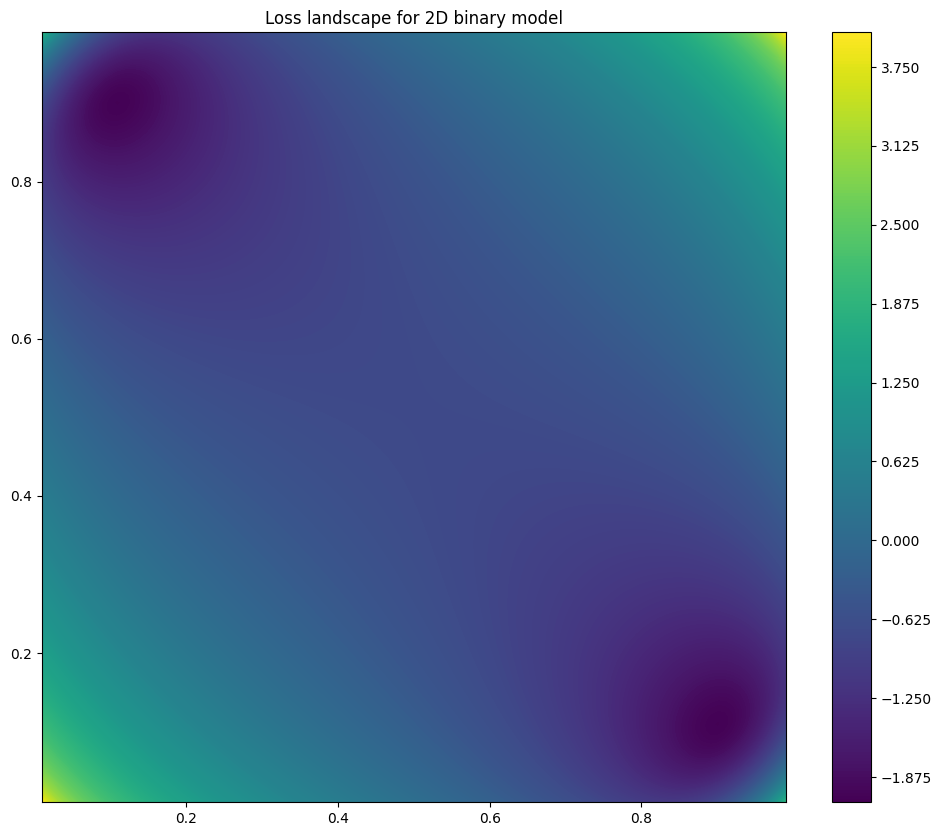

In [246]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,10))
plt.contourf(p1, p2, np.log(loss + 0.8), 300, cmap='viridis')
plt.colorbar()
plt.title("Loss landscape for 2D binary model")

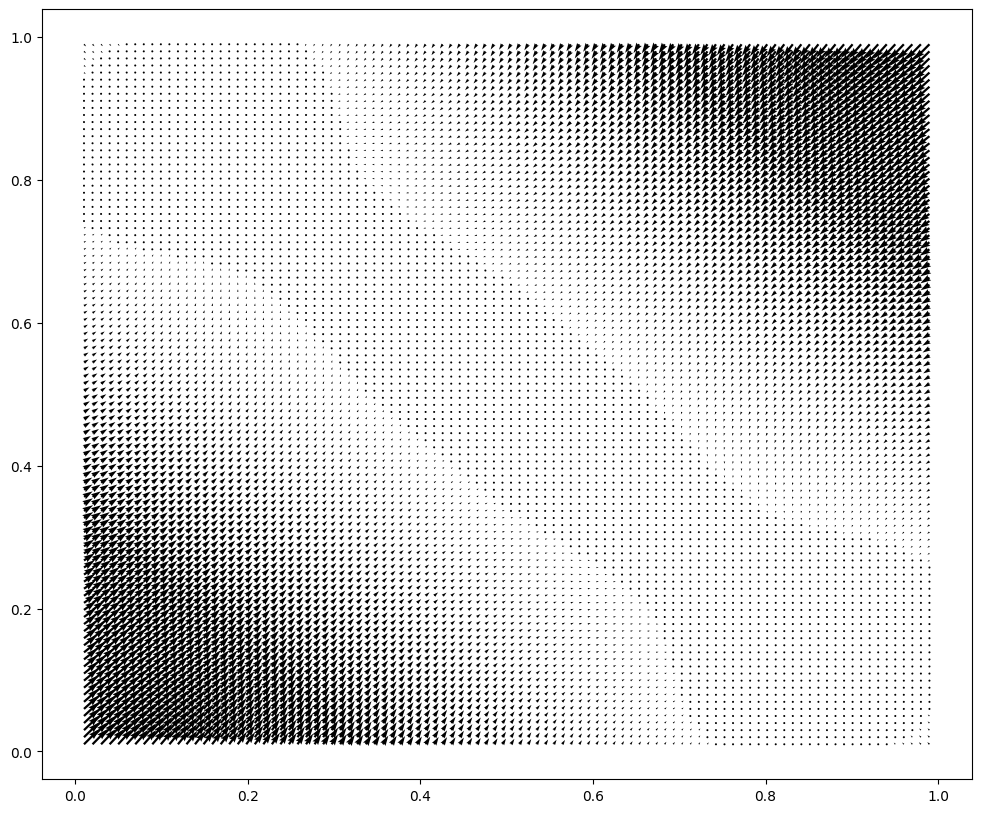

In [248]:
plt.figure(figsize=(12,10))
# plot gradient vector field grad
plt.quiver(p1, p2, -grad[0], -grad[1])

In [260]:
from jax.nn import sigmoid

In [ ]:
x = np.array([-4., -0.5, 0.1, 0.5, 4.])

Array([[-0.32589006, -0.00893444,  0.06887632,  0.45244455,  3.1737914 ],
       [-3.67411   , -0.49106556,  0.03112369,  0.04755545,  0.8262086 ]],      dtype=float32)

In [345]:
def loss_fn(beta, beta_star, x):
    p = sigmoid(x @ beta)
    p_star = sigmoid(x @ beta_star)
    mu = np.sum(p)
    mu_star = np.sum(p_star)
    phi2 = np.sum(p * (1 - p))
    phi2_star = np.sum(p_star * (1 - p_star))
    return np.log(phi2) + (mu - mu_star)**2 / phi2 + phi2_star / phi2

grad_fn = jax.jit(jax.grad(loss_fn))

In [425]:
def loss_fn(beta, beta_star, x):
    p = sigmoid(x @ beta)
    p_star = sigmoid(x @ beta_star)
    mu = np.sum(p)
    mu_star = np.sum(p_star)
    phi2 = np.sum(p * (1 - p))
    phi2_star = np.sum(p_star * (1 - p_star))
    return np.log(phi2) + (mu - mu_star)**2 / phi2 + phi2_star / phi2

grad_fn = jax.jit(jax.grad(loss_fn))

@jax.jit
def coef_fn(beta, beta_star, x):
    p = sigmoid(x @ beta)
    p_star = sigmoid(x @ beta_star)
    mu = np.sum(p)
    mu_star = np.sum(p_star)
    phi2 = np.sum(p * (1 - p))
    phi2_star = np.sum(p_star * (1 - p_star))
    return 2 * (mu_star - mu) / phi2 - ((mu - mu_star)**2 + phi2_star - phi2) / phi2**2 

In [426]:
b = np.linspace(-0.5, 2, 100)
coefs = []
for b1 in b:
    for b2 in b:
        coef = coef_fn(np.array([b1, b2]), np.ones(2), x.T)
        coefs.append(coef) 

coefs = np.array(coefs).reshape(100, 100)

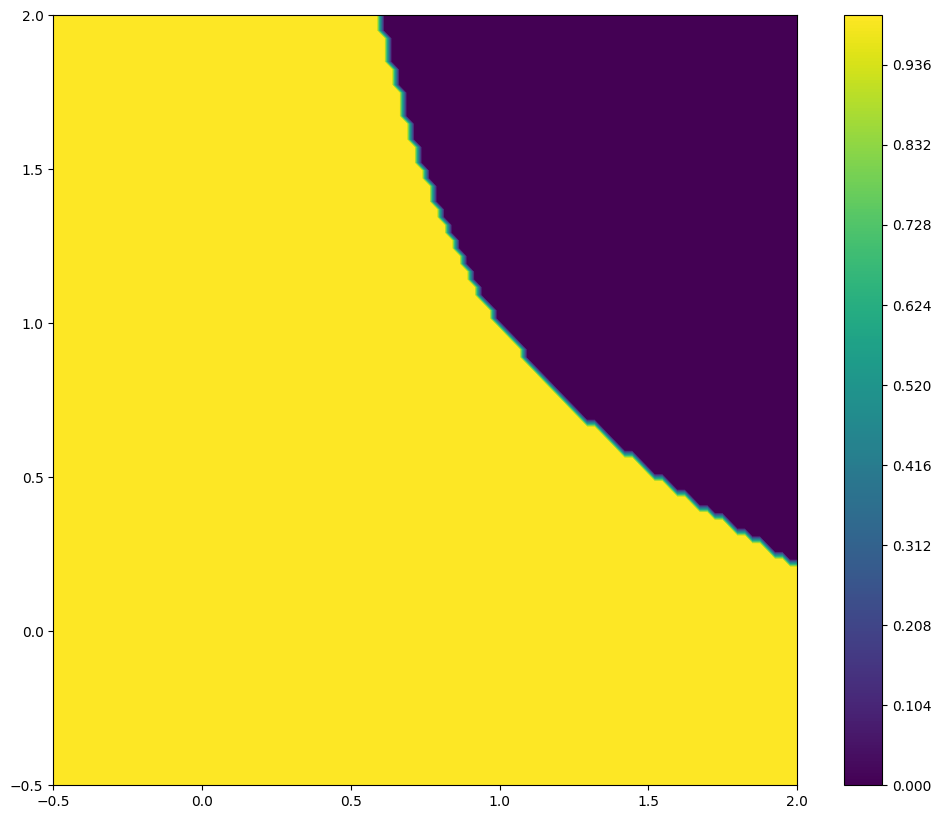

In [428]:
plt.figure(figsize=(12,10))
X, Y = np.meshgrid(b, b)
plt.contourf(X, Y, coefs > 0, 300, cmap='viridis')
plt.colorbar()

In [401]:
next_rng, rng = jax.random.split(rng)
x = np.array([-4., -0.5, 0.5, 4., 0.5])
# u = jax.random.uniform(next_rng, (5,))
u = jax.random.uniform(next_rng, (3,))
u = np.hstack((u, u[:2]))
x = x * np.vstack([u, 1 - u])


In [423]:
grad_fn(np.array([0.02947921, 0.02260297]), np.ones(2), x.T)

Array([-0.03691419, -0.023743  ], dtype=float32)

In [406]:
B = 200
b = np.linspace(-0.5, 2, B)
grads = []
grad_norms = []
for b1 in b:
    for b2 in b:
        grad = grad_fn(np.array([b1, b2]), np.ones(2), x.T)
        grads.append(grad) 
        grad_norms.append(np.linalg.norm(grad))

grads = np.array(grads)
grad_norms = np.array(grad_norms).reshape(B, B)

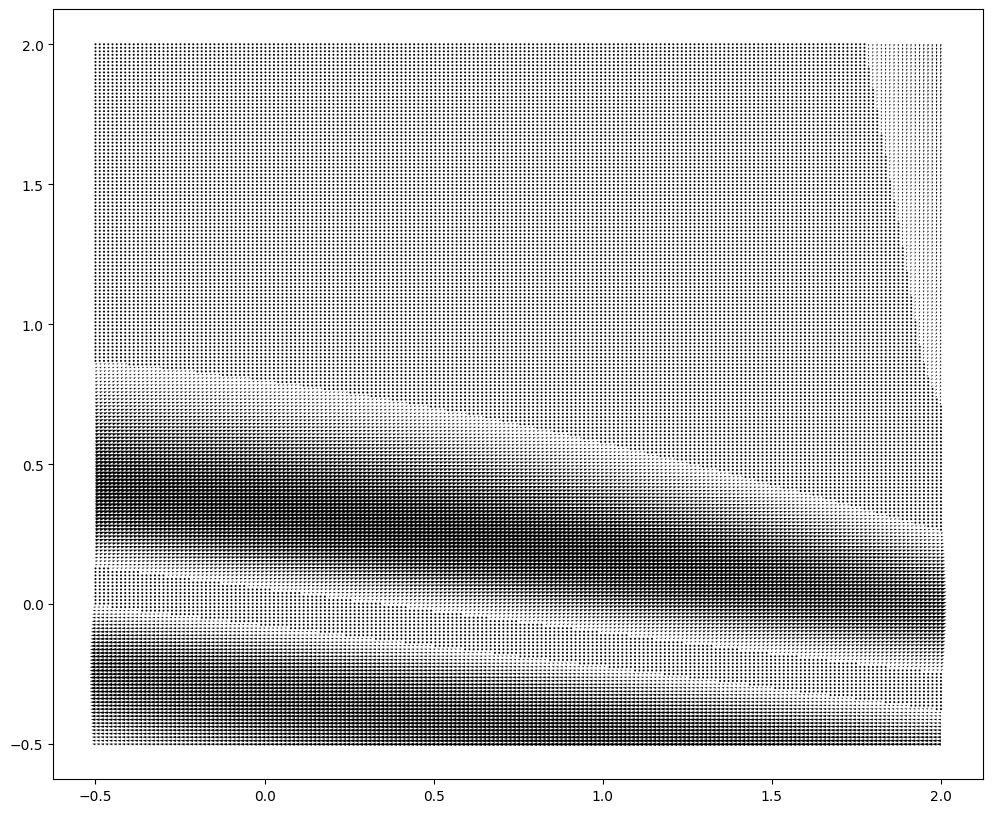

In [418]:
plt.figure(figsize=(12,10))
# plot gradient vector field grad
plt.quiver(b, b, -grads.reshape(B, B, 2)[:, :, 0], -grads.reshape(B, B, 2)[:, :, 1])

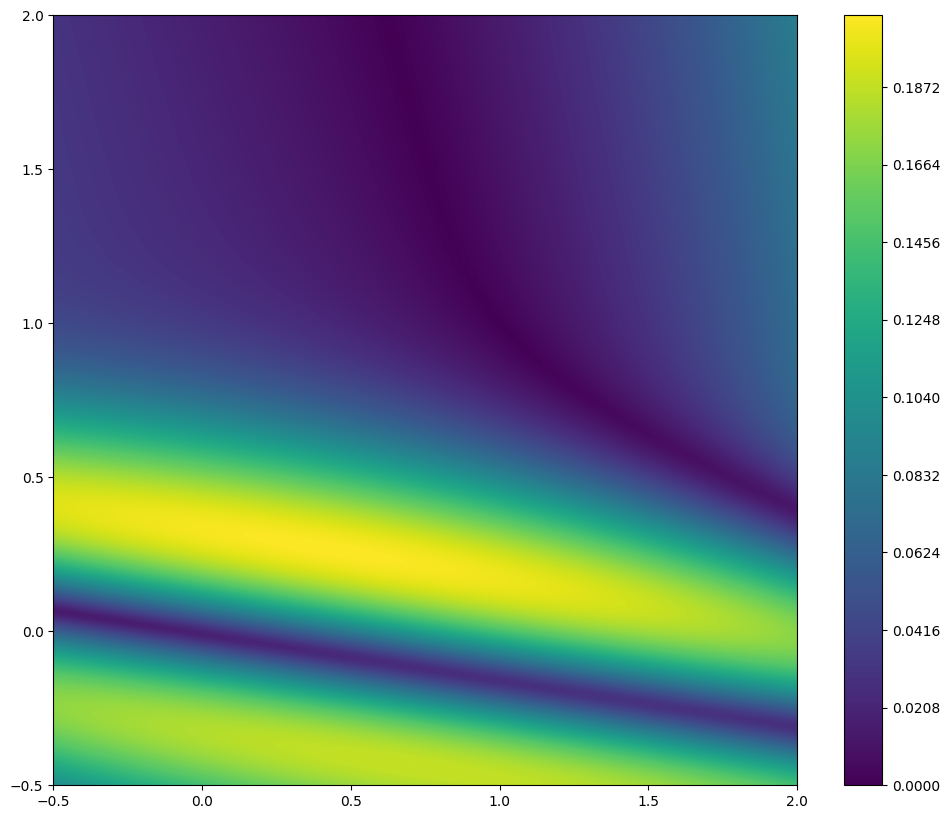

In [415]:
plt.figure(figsize=(12,10))
X, Y = np.meshgrid(b, b)
plt.contourf(X, Y, grad_norms, 300, cmap='viridis')
plt.colorbar()

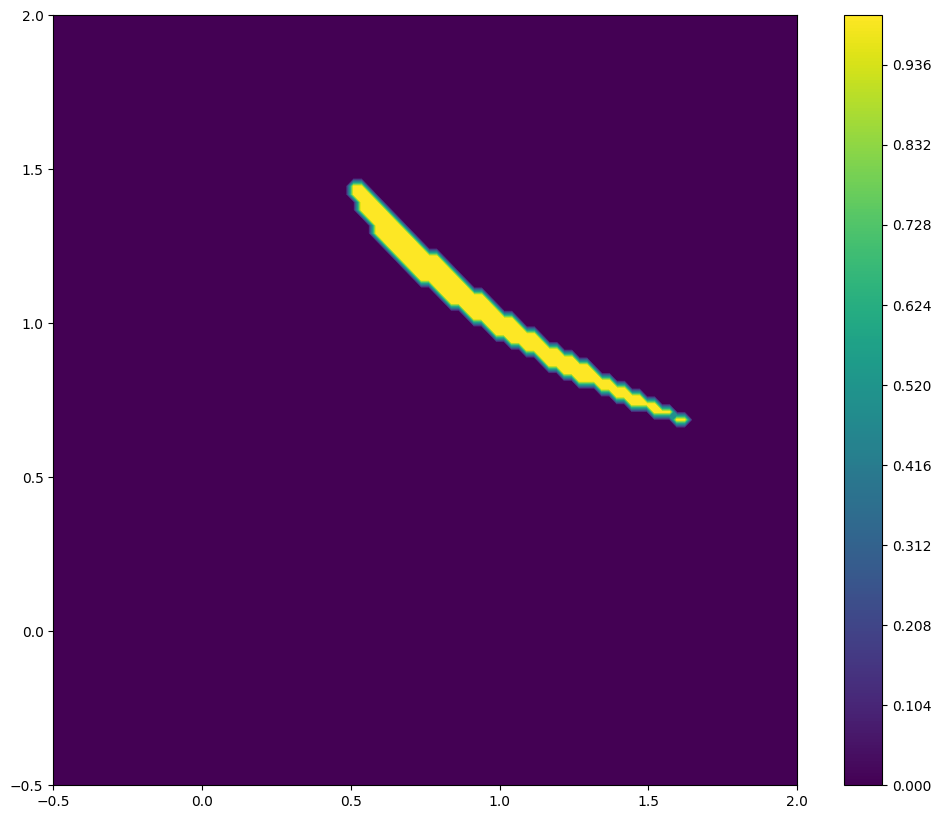

In [389]:
# plot the loss landscape

plt.figure(figsize=(12,10))
X, Y = np.meshgrid(b, b)
plt.contourf(X, Y, losses < 0.6994, 300, cmap='viridis')
plt.colorbar()


In [333]:
scipy.stats.chi2.ppf(0.95, d)

7.814727903251179

In [ ]:
(k - 1) * d / (k - d) * scipy.stats.f.ppf(0.95, d, k - d - 1)

18.636798406773845

In [ ]:
(np.array(fstats) <= 1 / k * (k - 1) * d / (k - d) * scipy.stats.f.ppf(0.95, d, k - d - 1)).mean()

Array(0.87333333, dtype=float32)

In [ ]:
(np.array(fstats) <= 1 / k * scipy.stats.chi2.ppf(0.95, d)).mean()

Array(0.7659574, dtype=float32)

In [ ]:
scipy.stats.chi2.ppf(0.95, 10 + 2), scipy.stats.chi2.ppf(0.95, 10)

(21.02606981748307, 18.307038053275146)

In [ ]:
W = get_bootstrap_weights(rng, G, 300)

In [ ]:
cg_fn = get_cg_fn(loss_and_grad_fn, hess_fn)

binary_params, gd_norm, history = fit(
    lyapunov_binary_loss, model_fn, np.tile(model_params[None, :], (300, 1)), (X, Y, G), group_weights=W[..., None],
    verbose=2, lr=1, print_every=1, tol=5e-5,
    maxit=100, mapped_loss_and_dir_fn=cg_fn, keep_history=True
)

2023-11-27 18:45:39.399155: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  slice.104 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-11-27 18:45:41.025261: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.627916s
Constant folding an instruction is taking > 1s:

  slice.104 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off betwe

0 	 1269.4014 	 2145.8992
1 	 388.3105 	 700.20197


KeyboardInterrupt: 

In [ ]:
fstats2 = np.array(fstats)

In [ ]:
# get quantile of fstatistics
scipy.stats.f.cdf((1 / k * (k - 1) * d / (k - d))**-1 * np.quantile(fstats2, 0.95), d, k - d)

0.9768516692845504

In [ ]:
cg_fn = get_cg_fn(mapped_loss_and_grad_fn, mapped_hess_fn)

boot_params, gd_norm, history = gd(
    lyapunov_binary_loss, model_fn, np.tile(binary_params, (1_000, 1)), group_data, group_weights=w[..., None],
    verbose=2, lr=1, print_every=1, tol=1e-4,
    maxit=100, mapped_loss_and_dir_fn=cg_fn, keep_history=True
)

0 	 -1.3092031 	 3.8715534
1 	 -1.3217705 	 0.026025068
2 	 -1.321771 	 5.8652247e-05
Converged!
2 -1.321771 5.8652247e-05


In [ ]:
np.percentile(boot_params, 97.5, axis=0), np.mean(boot_params, axis=0), np.percentile(boot_params, 2.5, axis=0)

(Array([-0.86597353, -0.3356535 ,  0.4129642 , -0.6760616 ,  0.63289416,
         0.01118292,  0.79537773, -0.09305118, -0.09374186,  0.3101299 ],      dtype=float32),
 Array([-0.87597793, -0.34300178,  0.40539646, -0.68573797,  0.6244735 ,
         0.00345865,  0.78631145, -0.10019332, -0.10153584,  0.30175263],      dtype=float32),
 Array([-0.88645166, -0.35060707,  0.3983707 , -0.69541305,  0.61590546,
        -0.00455674,  0.77769244, -0.10778944, -0.10931624,  0.29322946],      dtype=float32))

In [ ]:
# plot loss landscape
import matplotlib.pyplot as plt
# get meshgrid
t = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(t, t)
min_eighs = []
losses = []
for (x, y) in zip(X.flatten(), Y.flatten()):
    min_eighs.append(np.linalg.eigh(mapped_hess_fn(np.array([x, y]), (*group_data, w1)))[0][0])
    losses.append(mapped_loss_and_grad_fn(np.array([x, y]), (*group_data, w1))[0])


TypeError: Shapes must be 1D sequences of concrete values of integer type, got (None, 1).

In [ ]:
traj = np.array([h[0] for h in history])
traj = np.vstack([np.zeros(2), traj])

Text(0.5, 1.0, 'Minimum eigenvalue of Hessian for 2D binary model')

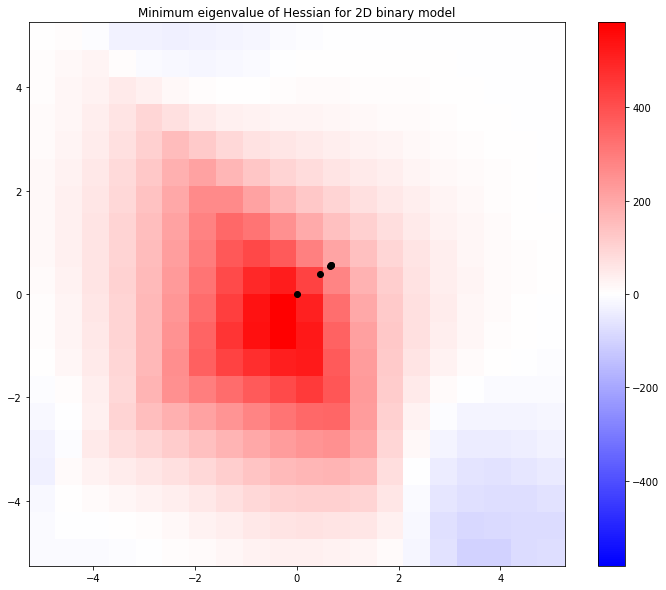

In [ ]:
import matplotlib.colors as colors
Z = np.array(min_eighs).reshape(X.shape)
norm = colors.TwoSlopeNorm(vmin=-Z.max(), vcenter=0, vmax=Z.max())

plt.figure(figsize=(12,10))

plt.pcolor(X, Y, Z, norm=norm, cmap="bwr") 
plt.plot(traj[:, 0], traj[:, 1], 'o', color="black")
# plt.plot(binary_params[0], binary_params[1], 'o', color='black') 
# plt.contourf(X, Y, Z, 15, norm=norm) 
plt.colorbar()
plt.title("Minimum eigenvalue of Hessian for 2D binary model")

Text(0.5, 1.0, 'Loss landscape for 2D binary model')

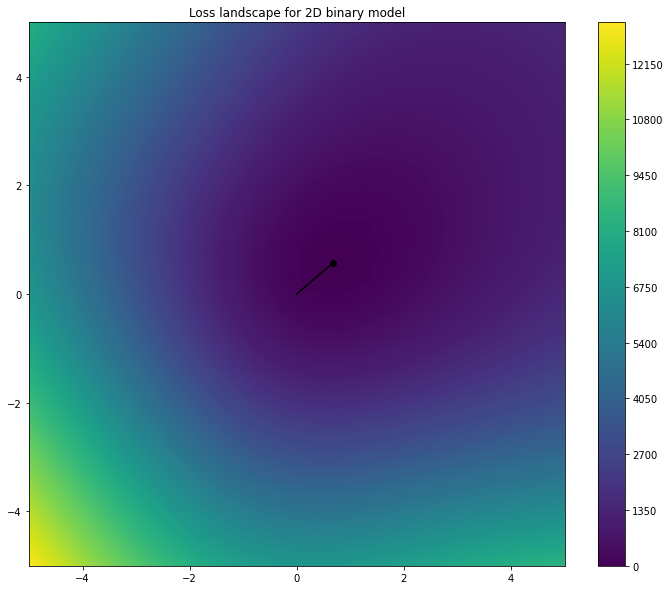

In [ ]:
plt.figure(figsize=(12,10))
plt.contourf(X, Y, np.array(losses).reshape(X.shape), 300, cmap='viridis')
plt.plot([0, binary_params[0]], [0, binary_params[1]], color="black")
plt.plot(binary_params[0], binary_params[1], 'o', color='black') 
plt.colorbar()
plt.title("Loss landscape for 2D binary model")

In [ ]:
import jax
import jax.numpy as np
from elrpy.models import binary_model

@jax.jit
def hess_exp_lyapunov_binary_loss(params, true_params, x):
    p = binary_model(params, x)
    phi2 = np.sum(p * (1 - p))
    mu = np.sum(p)
    

    p_star = binary_model(true_params, x)
    mu_star = np.sum(p_star)
    phi2_star = np.sum(p_star * (1 - p_star))
    # print(mu_star / x.shape[0], (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2), (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), -(mu_star - mu)/phi2, phi2_star/phi2, (mu_star - mu)**2/phi2, 1/2 * (mu_star - mu)**2/phi2**2, (mu_star - mu)/phi2)
    outer_x = np.einsum('...c,...d->...cd', x, x)
    phi2x = np.sum((p * (1 - p))[:, None] * x, axis=0)
    dphi2x = np.sum((p * (1 - p) * (1 - 2 * p))[:, None] * x, axis=0)
    dphi2xx = np.sum((p * (1 - p) * (1 - 2 * p))[:, None, None] * outer_x, axis=0)
    ddphi2xx = np.sum((p * (1 - p) * (1 + 6 * p * (p - 1)))[:, None, None] * outer_x, axis=0)
    
    t1 = 1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2) * ddphi2xx
    t2 = -(mu_star - mu)/phi2 * dphi2xx
    t3 = (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2) / phi2**2 * np.outer(dphi2x, dphi2x)
    t4 = 1 / phi2 * np.outer(phi2x, phi2x)
    
    hess = t1 + t2 + t3 + t4
    return 2 * hess, (t1, t2, t3, t4),  1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), (mu_star - mu)/phi2

In [ ]:
@jax.jit
def hess_t_lyapunov_binary_loss(t, true_params, x):
    params = t * true_params
    p = binary_model(params, x)
    phi2 = np.sum(p * (1 - p))
    mu = np.sum(p)
    
    p_star = binary_model(true_params, x)
    mu_star = np.sum(p_star)
    phi2_star = np.sum(p_star * (1 - p_star))

    x = (x @ params).T
    # print(mu_star / x.shape[0], (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2), (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), -(mu_star - mu)/phi2, phi2_star/phi2, (mu_star - mu)**2/phi2, 1/2 * (mu_star - mu)**2/phi2**2, (mu_star - mu)/phi2)
    outer_x = jax.vmap(np.dot)(x, x)
    phi2x = np.sum((p * (1 - p)) * x, axis=0)
    dphi2x = np.sum((p * (1 - p) * (1 - 2 * p)) * x, axis=0)
    dphi2xx = np.sum((p * (1 - p) * (1 - 2 * p)) * outer_x, axis=0)
    ddphi2xx = np.sum((p * (1 - p) * (1 + 6 * p * (p - 1))) * outer_x, axis=0)
    
    t1 = 1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2) * ddphi2xx
    t2 = -(mu_star - mu)/phi2 * dphi2xx
    t3 = (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2) / phi2**2 * np.dot(dphi2x, dphi2x)
    t4 = 1 / phi2 * np.dot(phi2x, phi2x)
    
    hess = t1 + t2 + t3 + t4
    return 2 * hess, (t1, t2, t3, t4),  1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), (mu_star - mu)/phi2

In [ ]:
group_data[0][1].shape

(1664, 2)

In [ ]:

for k in range(len(group_data[0])):
    H1, t, c1, d = hess_t_lyapunov_binary_loss(0, beta.flatten(), group_data[0][k])
    rng = jax.random.PRNGKey(k + 3)
    t = jax.random.uniform(rng)
    H, tt, c, d = hess_t_lyapunov_binary_loss(t, beta.flatten(), group_data[0][k])
    print(k, t, H1, H)

0 0.8653928 0.0 0.44589376
1 0.16215026 0.0 5.167947
2 0.6343405 0.0 2445.0427
3 0.51601326 0.0 5.756989
4 0.8441069 0.0 51.689354
5 0.9119096 0.0 103.78547
6 0.65711427 0.0 99.41739
7 0.08938682 0.0 10.154454
8 0.45246768 0.0 0.23940206
9 0.3037703 0.0 0.049302332
10 0.8186326 0.0 0.666452
11 0.22146237 0.0 3.042394
12 0.5277747 0.0 23.454403
13 0.55171585 0.0 273.4535
14 0.32842708 0.0 2.2261012
15 0.9378201 0.0 14.493642
16 0.744781 0.0 43.195858
17 0.22824931 0.0 30.833637
18 0.54728234 0.0 4.7123
19 0.9258436 0.0 9.599702
20 0.60175097 0.0 34.551525
21 0.12127352 0.0 0.3685405
22 0.37329996 0.0 170.65652
23 0.37956572 0.0 60.92818
24 0.026275992 0.0 7.043793e-05
25 0.39540493 0.0 819.3443
26 0.5139717 0.0 6.1677556
27 0.92384136 0.0 46.07413
28 0.7877443 0.0 25.033339
29 0.7519332 0.0 0.35792542
30 0.79524577 0.0 3.8019414
31 0.7453269 0.0 91.442505
32 0.33526587 0.0 0.007994495
33 0.27806175 0.0 39.234493
34 0.2462827 0.0 4.6576867
35 0.9958941 0.0 2.259924
36 0.49880707 0.0 2.05

In [ ]:
import jax
import jax.numpy as np
from elrpy.models import binary_model

# @jax.jit
def hess_exp_lyapunov_binary_loss(params, true_params, x):
    p = binary_model(params, x)
    phi2 = np.sum(p * (1 - p))
    mu = np.sum(p)
    

    p_star = binary_model(true_params, x)
    mu_star = np.sum(p_star)
    phi2_star = np.sum(p_star * (1 - p_star))
    outer_x = np.einsum('...c,...d->...cd', x, x)
    phi2x = np.sum((p * (1 - p))[:, None] * x, axis=0)
    dphi2x = np.sum((p * (1 - p) * (1 - 2 * p))[:, None] * x, axis=0)
    dphi2xx = np.sum((p * (1 - p) * (1 - 2 * p))[:, None, None] * outer_x, axis=0)
    ddphi2xx = np.sum((p * (1 - p) * (1 + 6 * p * (p - 1)))[:, None, None] * outer_x, axis=0)

    print(np.linalg.eigh(ddphi2xx)[0], (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2))
    
    t1 = 1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2) * ddphi2xx
    t2 = -(mu_star - mu)/phi2 * dphi2xx
    t3 = (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2) / phi2**2 * np.outer(dphi2x, dphi2x)
    t4 = 1 / phi2 * np.outer(phi2x, phi2x)
    
    
    hess = t1 + t2 + t3 + t4
    return 2 * hess, (t1, t2, t3, t4),  1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), (mu_star - mu)/phi2

In [ ]:
t = hess_exp_lyapunov_binary_loss(0.1 * beta.flatten(), beta.flatten(), group_data[0][10])[1]

[-105.01039   -28.52099   -27.590672  -23.940548  -23.102432  -21.498821
  -20.402363  -20.161726  -16.978083  -14.751165] -58.05064 58.55064


In [ ]:
1 / (group_data[0][k].shape[0] / 4)

0.035398230088495575

In [ ]:
np.linalg.eigh(t[3])

(Array([-6.6883564e-07, -3.7897973e-07, -9.9420383e-08, -5.8985815e-08,
        -3.7097745e-09,  5.1422515e-09,  1.2703302e-07,  2.7303113e-07,
         1.1207234e-06,  3.3735134e+01], dtype=float32),
 Array([[ 1.42447874e-01, -6.19293928e-01, -4.65404481e-01,
         -4.00122046e-01,  1.01541169e-01, -4.84616011e-02,
         -5.46195172e-02,  1.63150057e-01,  4.03289855e-01,
          1.20752558e-01],
        [-3.71568233e-01,  3.03750098e-01, -2.96154656e-02,
         -1.07412525e-02, -3.08179297e-04,  2.56513357e-02,
         -8.88244882e-02, -4.55806777e-03,  7.01024473e-01,
         -5.18340051e-01],
        [ 3.63032401e-01,  4.17383403e-01,  1.77417576e-01,
         -5.33726037e-01,  8.78660008e-02, -3.55825014e-02,
          4.08499926e-01, -2.72121549e-01,  2.50632346e-01,
          2.54818529e-01],
        [-1.07569352e-01,  2.63949960e-01,  4.37895767e-02,
         -1.34868035e-02,  7.22955689e-02,  1.42085515e-02,
          1.84720531e-01,  8.99538577e-01,  4.84003574e-02

In [ ]:
np.linalg.eigh(hess_exp_lyapunov_binary_loss(0.5 * beta.flatten(), beta.flatten(), group_data[0][k])[0])[0]

-0.70055306


Array([-0.11612222,  0.2271569 ,  0.48492092,  0.68342495,  0.7507059 ,
        0.7750699 ,  0.9355562 ,  1.002058  ,  1.2901878 , 70.381905  ],      dtype=float32)

In [ ]:
(binary_model(beta.flatten(), group_data[0][k]) * (1 - binary_model(beta.flatten(), group_data[0][k]))).mean()

Array(0.18954492, dtype=float32)

In [ ]:
(binary_model(beta.flatten(), group_data[0][k])).mean() * (1 - (binary_model(beta.flatten(), group_data[0][k])).mean())

Array(0.23862244, dtype=float32)

In [ ]:
(binary_model(beta.flatten(), group_data[0][k])).mean()

Array(0.6066656, dtype=float32)

In [ ]:
binary_model(beta.flatten(), group_data[0][k])

Array([0.5322552 , 0.71743584, 0.8440471 , 0.69025177, 0.86172175,
       0.92059845, 0.6529735 , 0.85587466, 0.44015113, 0.6972561 ,
       0.49392554, 0.54733324, 0.723354  , 0.6300325 , 0.91910267,
       0.599916  , 0.82093287, 0.70531505, 0.3291549 , 0.60666305,
       0.5962202 , 0.47623867, 0.96397877, 0.4828992 , 0.7665035 ,
       0.91347945, 0.486745  , 0.37603146, 0.46989706, 0.70501274,
       0.59922796, 0.17969178, 0.9615677 , 0.4463793 , 0.3818087 ,
       0.6415459 , 0.7709335 , 0.2870071 , 0.45871362, 0.8373599 ,
       0.7718902 , 0.55211943, 0.67444605, 0.58503544, 0.84869903,
       0.06722485, 0.13647027, 0.64404   , 0.61032516, 0.7544116 ,
       0.6239271 , 0.4644104 , 0.434181  , 0.67191213, 0.5214437 ,
       0.9748038 , 0.9647365 , 0.71103394, 0.7727409 , 0.29957807,
       0.686108  , 0.2882642 , 0.47191706, 0.18209156, 0.4838587 ,
       0.5738535 , 0.9434367 , 0.6240802 , 0.2989089 , 0.7555742 ,
       0.86754847, 0.52892554, 0.96130115, 0.676197  , 0.37405

In [ ]:
k = 268
rng = jax.random.PRNGKey(k + 2)
t = jax.random.uniform(rng)

In [ ]:

for k in range(len(group_data[0])):
    # H1, t, c1, d = hess_exp_lyapunov_binary_loss(0 * beta.flatten(), beta.flatten(), group_data[0][k])
    rng = jax.random.PRNGKey(k + 2)
    t = jax.random.uniform(rng)
    H, tt, c, d = hess_exp_lyapunov_binary_loss(t * beta.flatten(), beta.flatten(), group_data[0][k])
    print(k, t, binary_model(beta.flatten(), group_data[0][k]).mean(), np.linalg.eigh(H)[0])

0 0.4240216 0.38579786 [   4.145019     5.844952     6.4646573    6.546616     7.364783
    8.726075     9.621903     9.88111     10.110066  1311.0406   ]
1 0.8653928 0.41334665 [-2.95558628e-02  1.15390666e-01  1.34282336e-01  1.37348071e-01
  1.98832795e-01  2.19564706e-01  2.50059754e-01  3.06418538e-01
  4.08007681e-01  1.42460022e+02]
2 0.16215026 0.4114868 [   8.928448    9.373969   10.271558   10.591008   11.306983   12.791623
   13.888302   14.261965   15.0259   3155.1619  ]
3 0.6343405 0.26365554 [  7.943977  11.269225  13.202663  14.488474  15.219895  16.218792
  17.289703  19.047863  21.473368 981.5915  ]
4 0.51601326 0.14092675 [ 1865.5404  1959.4548  2085.1272  2158.4062  2183.6006  2249.4763
  2314.7683  2342.016   2447.9482 53930.184 ]
5 0.8441069 0.30870286 [  1.2155668   1.7894235   1.9152874   2.0313973   2.160241    2.5227706
   2.7562096   3.2339017   3.5637808 366.27426  ]
6 0.9119096 0.53934896 [-1.1595631e-02  2.5056545e-02  6.3855901e-02  7.4193247e-02
  1.05488

In [ ]:
n = 100
H = jax.hessian(lambda x, y: lyapunov_binary_loss(sigmoid(x), y, y))(np.ones(n) * 1/ 2, 0.75 * n)

In [ ]:
np.linalg.eigh(t[0])

(Array([-0.00059489,  0.00112573,  0.00171103,  0.00185994,  0.00244545,
         0.00263842,  0.00360414,  0.00418008,  0.00471196,  0.01049092],      dtype=float32),
 Array([[-0.43736583, -0.61813766,  0.06984194, -0.37308535,  0.23060748,
          0.03619352, -0.2920438 , -0.2159922 , -0.29928347,  0.08089706],
        [-0.15833649,  0.34297872,  0.28886408, -0.0161324 ,  0.48196712,
         -0.14468724, -0.1480574 ,  0.13414343,  0.19208393,  0.66599864],
        [ 0.14454944,  0.06879359, -0.5867334 ,  0.18590851,  0.4386176 ,
         -0.32643905, -0.4331654 , -0.22946444,  0.10760536, -0.2115233 ],
        [-0.4241231 , -0.23687679,  0.02104214,  0.3603713 ,  0.15748222,
          0.2727025 ,  0.21383236, -0.13736926,  0.66855145, -0.15157871],
        [ 0.44726452, -0.32035536,  0.22872183,  0.5356779 ,  0.0816997 ,
          0.05793631,  0.08726203, -0.44386876, -0.21740596,  0.31005126],
        [ 0.07313117, -0.28525826, -0.29340038, -0.05731076,  0.39454895,
         -0.2

In [ ]:
np.linalg.eigh(H)

(Array([0.0929051 , 0.09290527, 0.09290531, 0.09290534, 0.09290535,
        0.09290536, 0.09290537, 0.09290538, 0.09290539, 0.09290539,
        0.0929054 , 0.09290541, 0.09290541, 0.09290541, 0.09290542,
        0.09290543, 0.09290544, 0.09290544, 0.09290544, 0.09290544,
        0.09290544, 0.09290545, 0.09290545, 0.09290545, 0.09290545,
        0.09290545, 0.09290545, 0.09290545, 0.09290545, 0.09290546,
        0.09290546, 0.09290546, 0.09290546, 0.09290546, 0.09290546,
        0.09290546, 0.09290547, 0.09290547, 0.09290547, 0.09290547,
        0.09290547, 0.09290547, 0.09290548, 0.09290548, 0.09290548,
        0.09290548, 0.09290548, 0.09290548, 0.09290548, 0.09290548,
        0.09290548, 0.09290548, 0.09290548, 0.09290548, 0.09290548,
        0.09290549, 0.09290549, 0.09290549, 0.0929055 , 0.0929055 ,
        0.0929055 , 0.09290551, 0.09290551, 0.09290551, 0.09290551,
        0.09290551, 0.09290551, 0.09290551, 0.09290551, 0.09290551,
        0.09290551, 0.09290552, 0.09290552, 0.09

In [ ]:
np.diag(H) - np.sum(H - np.diag(np.diag(H)), axis=0)

Array([-0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 ,
       -0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 ,
       -0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 ,
       -0.2536845 , -0.2536845 , -0.2536845 , -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25

In [ ]:
from jax.scipy.special import expit as sigmoid

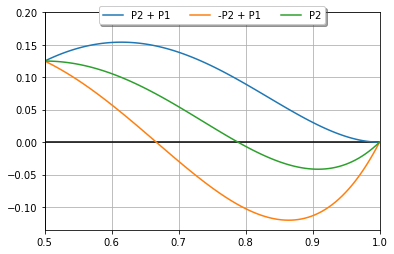

In [ ]:
import matplotlib.pyplot as plt

p = np.linspace(0.5, 1, 100)
plt.axhline(y=0., color='black', linestyle='-')
plt.axvline(x=0.5, color='black', linestyle='-')
# plt.plot(p, -p * (1 - p) * (1 - 2 * p), label="P2")
# plt.plot(p, p * (1 - p) * (1 - 2 * p), label="P2")
# plt.plot(p, -p * (1 - p) * (1 + 6 * p * (p - 1)), label="p (1 - p) (1 - 6p (p - 1))")
plt.plot(p, np.abs(p * (1 - p) * (1 - 2 * p)) - p * (1 - p) * (1 + 6 * p * (p - 1)), label="P2 + P1")
plt.plot(p, -np.abs(p * (1 - p) * (1 - 2 * p)) - p * (1 - p) * (1 + 6 * p * (p - 1)), label="-P2 + P1")
plt.plot(p, - p * (1 - p) * (1 + 6 * p * (p - 1)), label="P2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim([0.5, 1])
plt.ylim([-0.135, 0.2])
plt.grid('on')

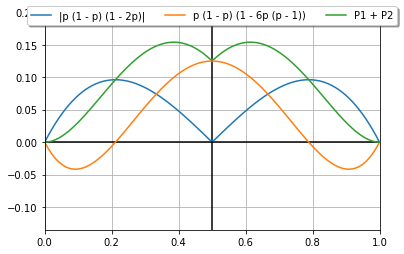

In [ ]:
import matplotlib.pyplot as plt

p = np.linspace(0, 1, 100)
plt.axhline(y=0., color='black', linestyle='-')
plt.axvline(x=0.5, color='black', linestyle='-')
plt.plot(p, np.abs(p * (1 - p) * (1 - 2 * p)), label="|p (1 - p) (1 - 2p)|")
plt.plot(p, -p * (1 - p) * (1 + 6 * p * (p - 1)), label="p (1 - p) (1 - 6p (p - 1))")
plt.plot(p, np.abs(p * (1 - p) * (1 - 2 * p)) - p * (1 - p) * (1 + 6 * p * (p - 1)), label="P1 + P2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim([0, 1])
plt.ylim([-0.135, 0.2])
plt.grid('on')

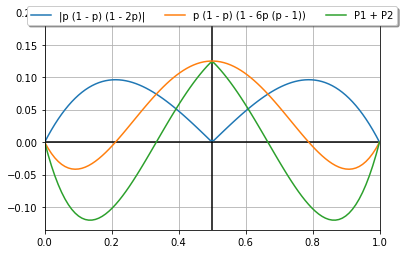

In [ ]:
import matplotlib.pyplot as plt

p = np.linspace(0, 1, 100)
plt.axhline(y=0., color='black', linestyle='-')
plt.axvline(x=0.5, color='black', linestyle='-')
plt.plot(p, np.abs(p * (1 - p) * (1 - 2 * p)), label="|p (1 - p) (1 - 2p)|")
plt.plot(p, -p * (1 - p) * (1 + 6 * p * (p - 1)), label="p (1 - p) (1 - 6p (p - 1))")
plt.plot(p, -np.abs(p * (1 - p) * (1 - 2 * p)) - p * (1 - p) * (1 + 6 * p * (p - 1)), label="P1 + P2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim([0, 1])
plt.ylim([-0.135, 0.2])
plt.grid('on')

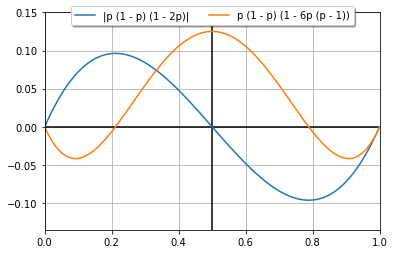

In [ ]:
import matplotlib.pyplot as plt

p = np.linspace(0, 1, 100)
plt.axhline(y=0., color='black', linestyle='-')
plt.axvline(x=0.5, color='black', linestyle='-')
plt.plot(p, (p * (1 - p) * (1 - 2 * p)), label="|p (1 - p) (1 - 2p)|")
plt.plot(p, -p * (1 - p) * (1 - 6 * p + 6 * p**2), label="p (1 - p) (1 - 6p (p - 1))")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fancybox=True, shadow=True)
plt.xlim([0, 1])
plt.ylim([-0.135, 0.15])
plt.ylim([-0.135, 0.15])
plt.grid('on')